## Part 2 - Data Cleaning
During our EDA we encountered some variables with incomplete or corrupted data.  
In this notebook we will use Pandas to:
* Remove outliers  
* Handle missing, null or corrupted values  

In [1]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
import geojson
import folium
from branca.colormap import LinearColormap, StepColormap

%matplotlib inline

## Preview the data 

In [2]:
df_dirty = pd.read_csv('./data/sf/data.csv')
df_dirty.head(5) # display first 5 entries of DataFrame

,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type,latlng
0,Condo For Sale,550 Davis St UNIT 44,San Francisco,CA,94111,1995000.0,"3 bds , 2 ba , 1,520 sqft",Sotheby's International Realty,https://www.zillow.com/homedetails/550-Davis-S...,3.0,2.0,1520.0,condo,NaN
1,Condo For Sale,240 Lombard St APT 437,San Francisco,CA,94111,625000.0,"1 bd , 1 ba , 566 sqft",SimpleListing.com,https://www.zillow.com/homedetails/240-Lombard...,1.0,1.0,566.0,condo,NaN
2,Condo For Sale,550 Davis St UNIT 39,San Francisco,CA,94111,1196000.0,"1 bd , 1 ba , 914 sqft",NaN,https://www.zillow.com/homedetails/550-Davis-S...,1.0,1.0,914.0,condo,NaN
3,Condo For Sale,77 Dow Pl APT 701,San Francisco,CA,94107,935000.0,"1 bd , 1.5 ba , 1,022 sqft",Vanguard Properties,https://www.zillow.com/homedetails/77-Dow-Pl-A...,1.0,1.5,1022.0,condo,NaN
4,House For Sale,807 Francisco St,San Francisco,CA,94109,16900000.0,"6 bds , 6.5 ba , 6,180 sqft",Compass,https://www.zillow.com/homedetails/807-Francis...,6.0,6.5,6180.0,house,"(37.8038257453414, -122.41844925566)"


## Remove outliers
Recall from our EDA that our price data has outliers which result in high skewness and kurtosis values.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: 4.273490547566425
Kurtosis: 24.274132451312706


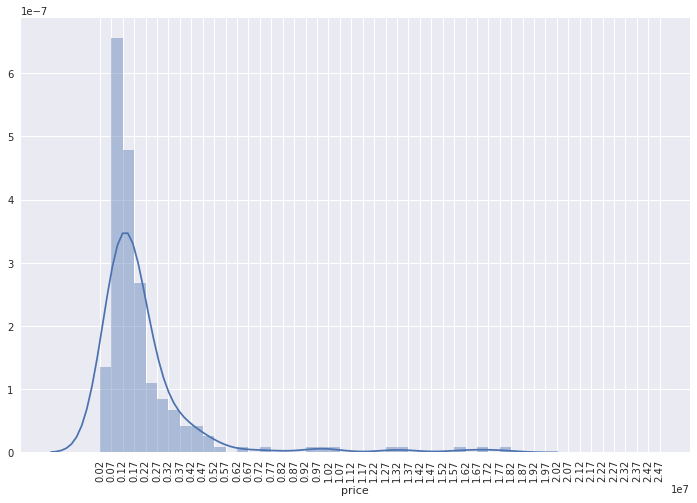

In [3]:
# globally set our seaborn plot size to 12 by 8 inches:
sns.set(rc={'figure.figsize':(12, 8)})

def plot_prices(dataframe: pd.DataFrame, bins: list):
    fig, ax = plt.subplots()
    ax.set_xticks(bins)
    plt.xticks(rotation='vertical')
    return sns.distplot(dataframe.price, bins=bins)

bins = range(int(df_dirty.price.min()),int(df_dirty.price.max()),500000)
bins
plot_prices(df_dirty.dropna(), bins)
print(f'Skewness: {df_dirty.price.skew()}')
print(f'Kurtosis: {df_dirty.price.kurt()}')

In [4]:
cutoff = 8e6
df_clean = df_dirty[df_dirty['price'] <= cutoff]

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: 2.069487
Kurtosis: 4.503858


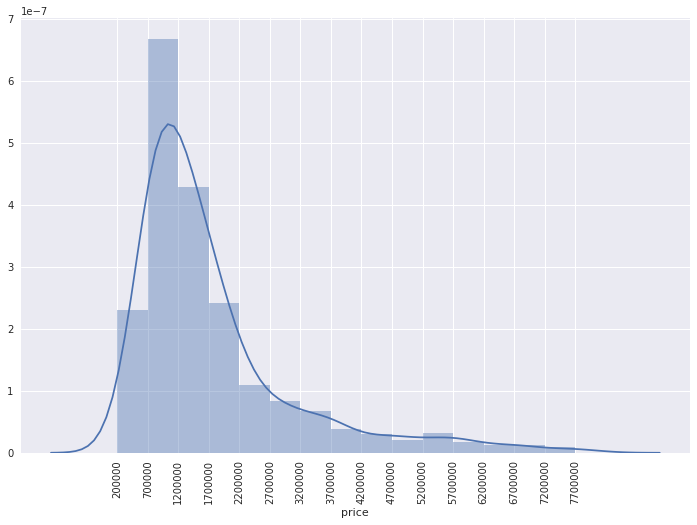

In [5]:
bins = range(int(df_clean.price.min()),int(df_clean.price.max()),500000)
plot_prices(df_clean, bins)
print("Skewness: %f" % df_clean['price'].skew())
print("Kurtosis: %f" % df_clean['price'].kurt())

The skewness and kurtosis values have improved. The distribution is still skewed however there are transformations we can apply to the dataset to make it more normally distributed. More on these transformations in a later notebook.

## Remove entries with `property_type` Land/Lot
In our EDA we encountered houses with zero square footage. This was due to listings of Land/Lot rather than House. Let's remove these entries since we are not interested in predicting Land/Lot value

In [6]:
num_zero_sqft = (df_dirty['sqft'] == 0).sum()
print("There are {} entries with zero sqft".format(num_zero_sqft))

There are 0 entries with zero sqft


In [7]:
df_clean = df_clean[df_clean['property_type'] != 'Land/Lot'] # only include entries which are NOT Land/Lot
num_zero_sqft = (df_clean['sqft'] == 0).sum()
print("There are {} entries with zero sqft".format(num_zero_sqft))

There are 0 entries with zero sqft


## Deal with Null and Missing values

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678 entries, 0 to 698
Data columns (total 14 columns):
title                   678 non-null object
address                 678 non-null object
city                    678 non-null object
state                   678 non-null object
postal_code             678 non-null int64
price                   678 non-null float64
facts and features      678 non-null object
real estate provider    533 non-null object
url                     678 non-null object
bed                     665 non-null float64
bath                    565 non-null float64
sqft                    620 non-null float64
property_type           671 non-null object
latlng                  435 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 79.5+ KB


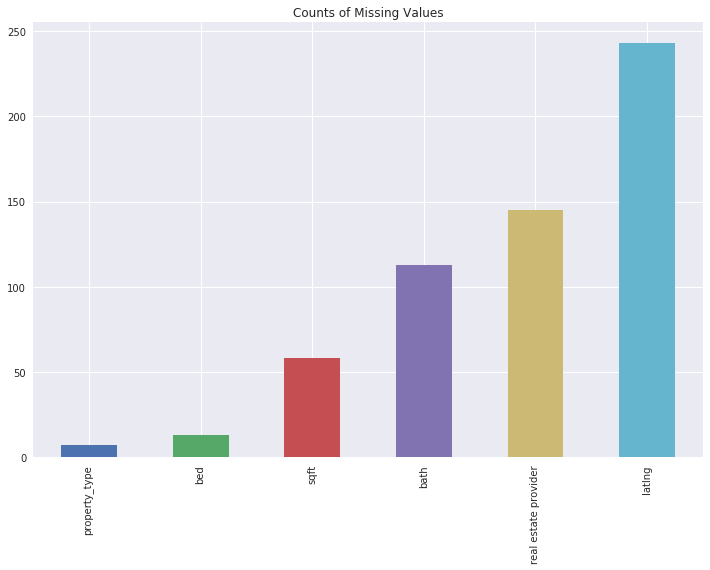

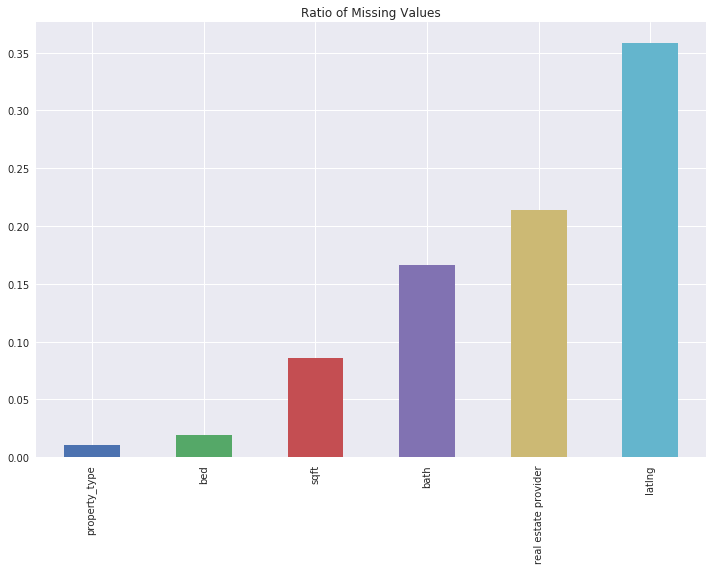

In [9]:
missing = df_clean.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.title("Counts of Missing Values")
plt.show()
missing_ratio = missing / len(df_clean)
missing_ratio.plot.bar()
plt.title("Ratio of Missing Values")
plt.show()

Rather than remove these missing values from the dataset, let's consider these numbers during Feature Selection in a later notebook.

 ## Save the dataframe to .csv file

In [10]:
df_clean.to_csv('./data/sf/data_clean.csv', index=False)